In [1]:
import uproot

import pandas as pd
import os, sys
from math import sqrt
# from sklearn import datasets

import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


from sklearn.metrics import accuracy_score,mean_squared_error, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import plot_importance
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

sys.path.append('/mnt/workspace/MyFiles/code')
from Preprocess import GoodMuonSelector
from dataset import muonDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)

Welcome to JupyROOT 6.24/02


In [81]:
print("Using device : ", device)

Using device :  cpu


In [3]:
batch_size = 64
epoch = 50
lr = 5e-5
drop_prob = 0.3

In [4]:
goodMuon = GoodMuonSelector()

sys.path.append('/mnt/workspace/MyFiles/')
higgs = goodMuon.getMuonData('/mnt/workspace/MyFiles/ntuple/ntuple_skim_mc_Higgs.root')
dy = goodMuon.getMuonData('/mnt/workspace/MyFiles/ntuple/ntuple_skim_mc_DY_50files.root')

Processing 0 evt...
Processing 10000 evt...
Processing 20000 evt...
Processing 30000 evt...
Processing 40000 evt...
Processing 50000 evt...
Processing 60000 evt...
Processing 70000 evt...
Processing 80000 evt...
Processing 90000 evt...
Processing 0 evt...
Processing 10000 evt...
Processing 20000 evt...
Processing 30000 evt...
Processing 40000 evt...
Processing 50000 evt...
Processing 60000 evt...
Processing 70000 evt...
Processing 80000 evt...
Processing 90000 evt...
Processing 100000 evt...
Processing 110000 evt...
Processing 120000 evt...
Processing 130000 evt...
Processing 140000 evt...
Processing 150000 evt...
Processing 160000 evt...
Processing 170000 evt...
Processing 180000 evt...
Processing 190000 evt...
Processing 200000 evt...
Processing 210000 evt...
Processing 220000 evt...
Processing 230000 evt...
Processing 240000 evt...
Processing 250000 evt...
Processing 260000 evt...
Processing 270000 evt...
Processing 280000 evt...
Processing 290000 evt...
Processing 300000 evt...
Pro

In [5]:
dset = muonDataset()

dset.load(higgs, 1)
dset.load(dy, 0)

Loading 0 evt...
Loading 10000 evt...
Loading 20000 evt...
Loading 0 evt...
Loading 10000 evt...
Loading 20000 evt...


In [16]:
trainsize = int(dset.__len__()*0.7)
validsize = dset.__len__() - trainsize

tData, vData = random_split(dset, [trainsize, validsize])

trainDataloader = DataLoader(dataset = tData, batch_size = batch_size, shuffle=True, drop_last = True)
validDataloader = DataLoader(dataset = vData, batch_size = batch_size, shuffle=True, drop_last = True)

In [19]:
model = nn.Sequential(
          nn.Linear(7, 64, bias=True), # input_layer = 7, hidden_layer1 = 32
          nn.ReLU(),
          #nn.Dropout(p=drop_prob),
          nn.Linear(64, 128, bias=True), # hidden_layer1 = 32, hidden_layer2 = 128
          nn.ReLU(),
          #nn.Dropout(p=drop_prob),
          nn.Linear(128, 32, bias=True), # hidden_layer2 = 128, hidden_layer3 = 32
          nn.ReLU(),
          #nn.Dropout(p=drop_prob),
          nn.Linear(32, 1, bias=True),# hidden_layer3 = 32, output_layer = 1
          nn.Sigmoid()
          ).to(device)

In [20]:
criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if (device == 'cuda') : print("Using GPU for training")

dnn_train_loss = []
dnn_train_acc = []
dnn_valid_loss = []
dnn_valid_acc = []
dnn_predict = []
dnn_label = []
    
for ep in range(epoch):
    trn_loss, trn_acc = 0., 0.
    model.train()
    optimizer.zero_grad()
    for x, y in trainDataloader:
            x = x.to(device)
            y = y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)
            
            loss.backward()
            optimizer.step()
            
            trn_loss += loss.item()
            trn_acc  += accuracy_score(y.to('cpu'), np.where(pred.to('cpu') > 0.5, 1, 0))
    trn_loss /= len(trainDataloader)
    trn_acc  /= len(trainDataloader)
    dnn_train_loss.append(trn_loss)
    dnn_train_acc.append(trn_acc)
    if(ep%1 == 0) :
        print("epoch = ", ep, " loss = ", trn_loss, " acc = ", trn_acc)
    
    val_loss, val_acc = 0., 0.
    model.eval()
    for x, y in validDataloader:
            x = x.to(device)
            y = y.to(device)
            
            pred = model(x)
            loss = criterion(pred, y)
            
            val_loss += loss.item()
            val_acc  += accuracy_score(y.to('cpu'), np.where(pred.to('cpu') > 0.5, 1, 0))
            
            dnn_predict.append(pred.detach().to('cpu').float())
            dnn_label.append(y.detach().to('cpu').float())
            
    val_loss /= len(validDataloader)
    val_acc  /= len(validDataloader)
    dnn_valid_loss.append(val_loss)
    dnn_valid_acc.append(val_acc)
    if(ep%1 == 0) :
        print("epoch = ", ep, " loss = ", val_loss, " acc = ", val_acc)
        print("")

epoch =  0  loss =  0.6938095988794618  acc =  0.5931799579045838
epoch =  0  loss =  0.5859949363631453  acc =  0.6662800218340611

epoch =  1  loss =  0.5512020281813098  acc =  0.6866668615528532
epoch =  1  loss =  0.5139365922415621  acc =  0.7222639192139738

epoch =  2  loss =  0.5357485278060885  acc =  0.7079192001870908
epoch =  2  loss =  0.5527921665183322  acc =  0.7003957423580786

epoch =  3  loss =  0.5236369148942218  acc =  0.7189107811038353
epoch =  3  loss =  0.5101644366849458  acc =  0.7553220524017468

epoch =  4  loss =  0.5134511298392843  acc =  0.7347550280636108
epoch =  4  loss =  0.5135698963330823  acc =  0.7413346069868996

epoch =  5  loss =  0.49385475847518145  acc =  0.7476613657623947
epoch =  5  loss =  0.4883811184933092  acc =  0.7527974890829694

epoch =  6  loss =  0.48097503073757447  acc =  0.7636810102899907
epoch =  6  loss =  0.48009884858495805  acc =  0.7853097707423581

epoch =  7  loss =  0.47244929807335556  acc =  0.7684459775491114

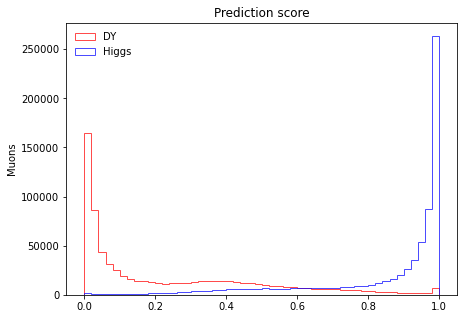

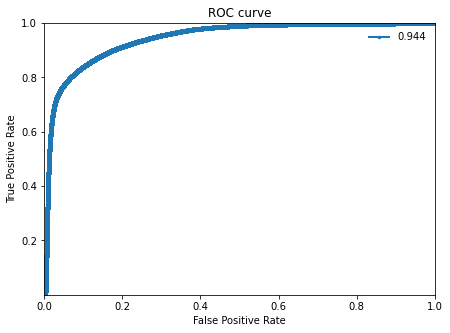

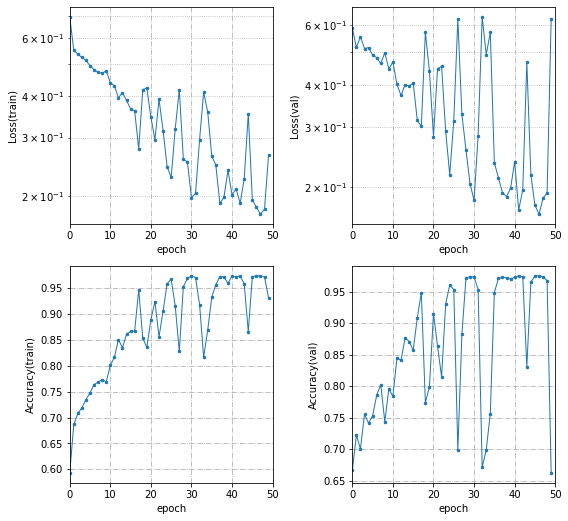

In [82]:
pred = []
l = []

for i in range(len(dnn_predict)):
    pred.extend(x.item() for x in dnn_predict[i].view(-1))
for i in range(len(dnn_label)):
    l.extend(y.item() for y in dnn_label[i].view(-1))

df_dnn = pd.DataFrame({'pred' : pred, 'label' : l})
df_sig = df_dnn[df_dnn.label==1]
df_bkg = df_dnn[df_dnn.label==0]

# Draw pred score plot
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams["legend.loc"] = 'upper left'
hbkg1 = df_bkg['pred'].plot(kind='hist', histtype='step', bins=50, alpha=0.7, color='red', label='DY')
hsig1 = df_sig['pred'].plot(kind='hist', histtype='step', bins=50, alpha=0.7, color='blue', label='Higgs')
plt.ylabel('Muons')
plt.legend()
plt.title('Prediction score')
plt.savefig('/mnt/workspace/MyFiles/model_plots/score_plot.jpg')
plt.show()

# Draw roc curve
tpr, fpr, thr = roc_curve(df_dnn['label'], df_dnn['pred'], pos_label=0)
auc = roc_auc_score(df_dnn['label'], df_dnn['pred'])
plt.rcParams['figure.figsize'] = [7, 5]
plt.plot(fpr, tpr, '.-', label='%.3f' % (auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1.000)
plt.ylim(1e-10, 1.000)
plt.legend(loc=0)
plt.title('ROC curve')
plt.savefig('/mnt/workspace/MyFiles/model_plots/roc_curve.jpg')
plt.show()

# Draw loss acc plot
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5
plt.rcParams["legend.loc"] = 'upper right'
plt.rcParams["legend.frameon"] = False
plt.rcParams["legend.loc"] = 'upper left'
plt.rcParams['figure.figsize'] = (4*2, 3.5*3)
ax1 = plt.subplot(3, 2, 1, yscale='log', ylabel='Loss(train)', xlabel='epoch')
ax2 = plt.subplot(3, 2, 2, yscale='log', ylabel='Loss(val)', xlabel='epoch')
ax3 = plt.subplot(3, 2, 3, ylabel='Accuracy(train)', xlabel='epoch')
ax4 = plt.subplot(3, 2, 4, ylabel='Accuracy(val)', xlabel='epoch')

name = ""
for ax in (ax1, ax2, ax3, ax4):
    ax.grid(which='major', axis='both', linestyle='-.')
    ax.grid(which='minor', linestyle=':')
    ax.set_xlim([0,50])


ax1.plot(dnn_train_loss, '.-', label='dnn')
ax2.plot(dnn_valid_loss, '.-', label='dnn')

ax3.plot(dnn_train_acc, '.-', label='dnn')
ax4.plot(dnn_valid_acc, '.-', label='dnn')
plt.tight_layout()
plt.savefig('/mnt/workspace/MyFiles/model_plots/Acc_Loss_plot.jpg')
plt.show()

In [33]:
xgb = XGBClassifier(n_estimators=400, n_jobs=6, learning_rate=0.001, max_depth = 6, random_state = 0, eval_metric='rmse', use_label_encoder=False)

xgb_X_train = []
xgb_Y_train = []
xgb_X_valid = []
xgb_Y_valid = []

for i in range(len(tData)):
    xgb_X_train.append(np.array(tData[i][0]))
    xgb_Y_train.append(tData[i][1].item())
    
for i in range(len(vData)):
    xgb_X_valid.append(np.array(vData[i][0]))
    xgb_Y_valid.append(vData[i][1].item())
    
xgb.fit(xgb_X_train, xgb_Y_train)
xgb_pred = xgb.predict(xgb_X_valid)

In [55]:
print("Xgboost train score =", round(xgb.score(xgb_X_train, xgb_Y_train), 4))
print("Xgboost valid score =", round(xgb.score(xgb_X_valid, xgb_Y_valid), 4))
print("Xgboost valid set AUC = ", round(roc_auc_score(xgb_Y_valid, xgb_pred), 4))

Xgboost train score = 0.9805
Xgboost valid score = 0.9795
Xgboost valid set AUC =  0.9794


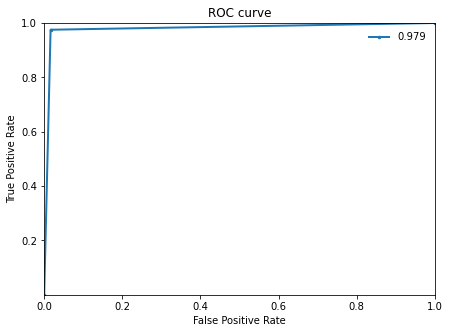

In [83]:
df_xgb = pd.DataFrame({'pred' : xgb_pred, 'label' : xgb_Y_valid})
tpr, fpr, thr = roc_curve(df_xgb['label'], df_xgb['pred'], pos_label=0)
auc = roc_auc_score(df_xgb['label'], df_xgb['pred'])
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 5
plt.plot(fpr, tpr, '.-', label='%.3f' % (auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0, 1.000)
plt.ylim(1e-10, 1.000)
plt.legend(loc=0)
plt.title('ROC curve')
plt.savefig('/mnt/workspace/MyFiles/model_plots/xgb_roc_curve.jpg')
plt.show()